In [1]:
!unzip /content/n200749@rguktn.ac.in.zip

Archive:  /content/n200749@rguktn.ac.in.zip
   creating: n200749@rguktn.ac.in/
  inflating: n200749@rguktn.ac.in/.DS_Store  
  inflating: __MACOSX/n200749@rguktn.ac.in/._.DS_Store  
  inflating: n200749@rguktn.ac.in/config.json  
   creating: n200749@rguktn.ac.in/submissions/
   creating: n200749@rguktn.ac.in/data/
   creating: n200749@rguktn.ac.in/data/corpus/
   creating: n200749@rguktn.ac.in/data/sentiment/
  inflating: n200749@rguktn.ac.in/data/corpus/questions.json  
  inflating: n200749@rguktn.ac.in/data/corpus/docs.jsonl  
  inflating: n200749@rguktn.ac.in/data/sentiment/test.csv  
  inflating: n200749@rguktn.ac.in/data/sentiment/dev.csv  
  inflating: n200749@rguktn.ac.in/data/sentiment/train.csv  


In [ ]:
!pip install pandas scikit-learn transformers torch sentencepiece

In [2]:
import pandas as pd

train_path = '/content/folderr/data/sentiment/train.csv'
dev_path = '/content/folderr/data/sentiment/dev.csv'
test_path = '/content/folderr/data/sentiment/test.csv'

train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

print(train_df.head())
print(dev_df.head())

                                                text  label
0  audio is muffled MangoByte power bank. bluetoo...      0
1  impressive results Qubitron power bank. noise-...      1
2  honestly Aster streaming stick: documentation ...      1
3  UI is a mess graphics card from BluePeak. blue...      0
4  impressive results Aster streaming stick. pair...      1
                                                text  label
0  broken out of the box Acme earbuds. firmware f...      0
1  overall superb quality OrionTech update — pair...      1
2  honestly NovaCore graphics card: surprisingly ...      1
3  honestly pleasant surprise Banyan keyboard — p...      1
4  honestly awful build PineLabs smartwatch — blu...      0


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['text'])
X_dev = vectorizer.transform(dev_df['text'])
X_test = vectorizer.transform(test_df['text'])

y_train = train_df['label']
y_dev = dev_df['label']

clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

y_pred_dev = clf.predict(X_dev)
print(classification_report(y_dev, y_pred_dev))


              precision    recall  f1-score   support

           0       0.52      0.61      0.56        18
           1       0.74      0.67      0.70        30

    accuracy                           0.65        48
   macro avg       0.63      0.64      0.63        48
weighted avg       0.66      0.65      0.65        48



In [10]:
y_test_pred = clf.predict(X_test)


submission = pd.DataFrame({
    'text': test_df['text'],
    'label': y_test_pred
})

submission_path = '/content/folderr/submissions/sentiment_test_predictions_app1.csv'
submission.to_csv(submission_path, index=False)
print(f"Saved predictions to {submission_path}")


Saved predictions to /content/folderr/submissions/sentiment_test_predictions_app1.csv


In [5]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_df.to_dict('list'))
dev_encodings   = tokenize(dev_df.to_dict('list'))
test_encodings  = tokenize(test_df.to_dict('list'))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_df['label'].tolist())
dev_dataset   = SentimentDataset(dev_encodings, dev_df['label'].tolist())
test_dataset  = SentimentDataset(test_encodings, [0]*len(test_df))


In [11]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


for i, layer in enumerate(model.distilbert.transformer.layer):
    if i < len(model.distilbert.transformer.layer) - 1:
        for param in layer.parameters():
            param.requires_grad = False

for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    eval_steps=50,
    logging_steps=10,
    save_strategy='no',
    learning_rate=5e-5,
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)


trainer.train()

train_loss = []
eval_loss = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

print("Training loss (logged every step):", train_loss)
print("Evaluation loss (per eval_steps / epoch):", eval_loss)



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.722000
20,0.670600
30,0.762400
40,0.710500
50,0.688000
60,0.665900
70,0.697100
80,0.708200
90,0.738100
100,0.656200


Training loss (logged every step): [0.722, 0.6706, 0.7624, 0.7105, 0.688, 0.6659, 0.6971, 0.7082, 0.7381, 0.6562, 0.649, 0.5794, 0.6873, 0.6521, 0.622, 0.5388, 0.5748, 0.5029, 0.4473, 0.3507, 0.403, 0.22, 0.2571, 0.2593, 0.4604, 0.3648, 0.2851, 0.3996, 0.0641, 0.0569, 0.1129, 0.1079, 0.844, 0.1213, 0.1573, 0.1455, 0.5574, 0.0885, 0.0119, 0.0089, 0.0701, 0.0034, 0.2494, 0.1894, 0.3273, 0.2138, 0.2722, 0.2027, 0.0017, 0.1288, 0.0057, 0.1451, 0.0321, 0.1764, 0.1667, 0.003, 0.0133, 0.1268, 0.0375, 0.0032, 0.0292, 0.0041, 0.3129, 0.0008, 0.0012, 0.0301, 0.0084, 0.0826, 0.006, 0.0084, 0.0064, 0.1584, 0.0004, 0.3453, 0.0032, 0.0992, 0.02, 0.116, 0.2044, 0.0007, 0.0039, 0.0406, 0.0019, 0.0008, 0.0018, 0.0005, 0.0015, 0.0021, 0.0016, 0.0598, 0.0041, 0.0022, 0.0109, 0.0636, 0.0013, 0.0005, 0.0026, 0.0002, 0.0091, 0.0002, 0.0018, 0.0067, 0.0094, 0.0011, 0.0002, 0.0016, 0.001, 0.0138, 0.0061, 0.0199, 0.0012, 0.0004]
Evaluation loss (per eval_steps / epoch): []


In [12]:
import numpy as np


eval_results = trainer.evaluate(eval_dataset=dev_dataset)

preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values

accuracy = (y_pred == y_true).mean()
print(f"Accuracy on dev set: {accuracy:.4f}")


Accuracy on dev set: 0.9375


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values


accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on dev set: {accuracy:.4f}")


report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:\n", report)


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy on dev set: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0     0.9412    0.8889    0.9143        18
           1     0.9355    0.9667    0.9508        30

    accuracy                         0.9375        48
   macro avg     0.9383    0.9278    0.9326        48
weighted avg     0.9376    0.9375    0.9371        48


Confusion Matrix:
 [[16  2]
 [ 1 29]]


In [13]:
import pandas as pd
import numpy as np

preds_output = trainer.predict(test_dataset)

y_test_pred = np.argmax(preds_output.predictions, axis=1)

submission = pd.DataFrame({
    'text': test_df['text'],
    'label': y_test_pred
})

submission_path = '/content/folderr/submissions/sentiment_test_predictions.csv'
submission.to_csv(submission_path, index=False)

print(f"Saved predictions to {submission_path}")


Saved predictions to /content/folderr/submissions/sentiment_test_predictions.csv


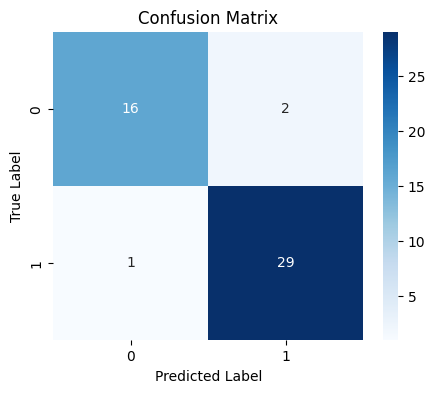

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on dev set
preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [16]:
plt.savefig('confusion_matrix.png', dpi=300)


<Figure size 640x480 with 0 Axes>

In [17]:
# Install emoji library
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 17.8 MB/s eta 0:00:00


In [3]:

import emoji
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np


# -----------------------
# Emoji preprocessing
# -----------------------
def demojize_text(text):
    return emoji.demojize(text)

train_df['text'] = train_df['text'].apply(demojize_text)
dev_df['text']   = dev_df['text'].apply(demojize_text)
test_df['text']  = test_df['text'].apply(demojize_text)

# Example
print(train_df['text'].head())

0    audio is muffled MangoByte power bank. bluetoo...
1    impressive results Qubitron power bank. noise-...
2    honestly Aster streaming stick: documentation ...
3    UI is a mess graphics card from BluePeak. blue...
4    impressive results Aster streaming stick. pair...
Name: text, dtype: object


In [4]:

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_df.to_dict('list'))
dev_encodings   = tokenize(dev_df.to_dict('list'))
test_encodings  = tokenize(test_df.to_dict('list'))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_df['label'].tolist())
dev_dataset   = SentimentDataset(dev_encodings, dev_df['label'].tolist())
test_dataset  = SentimentDataset(test_encodings, [0]*len(test_df))  # dummy labels

In [7]:

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

for i, layer in enumerate(model.distilbert.transformer.layer):
    if i < len(model.distilbert.transformer.layer) - 1:
        for param in layer.parameters():
            param.requires_grad = False

for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    eval_steps=50,
    logging_steps=10,
    save_strategy='no',
    learning_rate=5e-5,
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.728300
20,0.681000
30,0.731600
40,0.681100
50,0.662900
60,0.663300
70,0.711500
80,0.730300
90,0.713100
100,0.645900


TrainOutput(global_step=1120, training_loss=0.1814287815267952, metrics={'train_runtime': 15.7939, 'train_samples_per_second': 141.827, 'train_steps_per_second': 70.913, 'total_flos': 35352237016320.0, 'train_loss': 0.1814287815267952, 'epoch': 10.0})

In [10]:
import numpy as np


eval_results = trainer.evaluate(eval_dataset=dev_dataset)

preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values

accuracy = (y_pred == y_true).mean()
print(f"Accuracy on dev set: {accuracy:.4f}")


Accuracy on dev set: 0.9167


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values


accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on dev set: {accuracy:.4f}")


report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:\n", report)


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy on dev set: 0.9167

Classification Report:
               precision    recall  f1-score   support

           0     0.9375    0.8333    0.8824        18
           1     0.9062    0.9667    0.9355        30

    accuracy                         0.9167        48
   macro avg     0.9219    0.9000    0.9089        48
weighted avg     0.9180    0.9167    0.9156        48


Confusion Matrix:
 [[15  3]
 [ 1 29]]


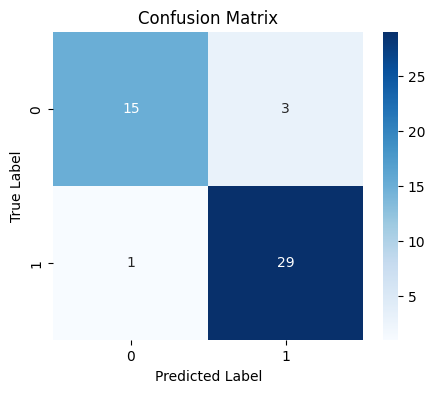

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on dev set
preds_output = trainer.predict(dev_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dev_df['label'].values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
